In [1]:
import yt
from yt import YTArray
from yt import YTQuantity

from astropy import constants as const

import numpy as np

import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
from matplotlib.colors import SymLogNorm, LogNorm

import palettable

In [2]:
folder = 'test'
output = 3

ds = yt.load('../../simulations/cluster/DD0000/DD0000')

def _drho_over_rho(field, data):
    z = data[('gas', 'z')]
    rho = data[('gas', 'density')]
    print(np.shape(z))
    res = int( abs(z[0] - z[-1]) / abs(z[0] - z[1])) + 1
    drho_over_rho = np.zeros(len(z))
    
    for i in range(res):
        mask = z == z[i]
        ave_rho = np.mean(rho[mask])
        drho_over_rho[mask] = (rho[mask] - ave_rho) / ave_rho
    return drho_over_rho 
    
    
def _accel_z(field, data):
    accel_unit = ds.length_unit.value / ds.time_unit.value**2
    accel = data[('enzo', 'External_Acceleration_z')] * accel_unit
    return YTArray(accel, 'cm/s**2')

def _ff_time(field, data):
    z = data[('gas', 'z')]
  #  z_midpoint = (z[-1] - z[0]) / 2.0
  #  z -= z_midpoint
    return np.sqrt(abs(2.0 * z / data[('gas', 'external_acceleration_z')]))

def _cool_ff_ratio(field, data):
    return data[('gas', 'cooling_time')] / data[('gas', 'free_fall_time')]

def _cool_test(field, data, power_law_index = -2.0/3.0):
    L0 =  4.490093e-19
#    L0 =  4.490093e-23
    kb = const.k_B.cgs.value
    rho = data[('gas', 'density')].in_units('g/cm**3')
    T = data[('gas', 'temperature')]
    mu = 1.22
    mh = const.m_p.cgs.value
    
    cool_time = 3*kb * mu * mh * np.power(T, 1.0 - power_law_index) / (2 * rho * L0)
    return YTArray(cool_time.d, 's')

    

def load(output, folder = 'tcool_tff_10'):
    ds = yt.load('../../simulations/%s/DD%04d/DD%04d'%\
                 (folder, output, output))

    #ds.add_field(('gas', 'density_fluctuation'), function = _drho_over_rho, \
    #             display_name = 'Density Fluctuation', units = '')
    ds.add_field(('gas', 'external_acceleration_z'), function = _accel_z, \
                display_name = 'External Acceleration Z', units = 'cm/s**2')

    ds.add_field(('gas', 'free_fall_time'), function = _ff_time, \
                display_name = 'Free Fall Time', units = 's')

    ds.add_field(('gas', 'tcool_tff_ratio'), function = _cool_ff_ratio, \
                display_name = 'Cooling Time / Free Fall Time', units = '')
    ds.add_field(('gas', 'cool_time_test'), function = _cool_test, \
                display_name = 'Cooling Time (test)', units = 'yr')
    
    return ds

def plot_density_slices(ds, folder = '.', half_range = 1.0, rho0 = 1e-27):

    s = yt.SlicePlot(ds, 'x', ('gas', 'density'))
    frb_s = s.frb
    p = yt.ProjectionPlot(ds, 'x', ('gas', 'density'), weight_field = 'ones')
    frb_p = p.frb

    cmap_list = [palettable.cmocean.sequential.Tempo_20.mpl_colormap, \
                 palettable.cmocean.diverging.Curl_9.mpl_colormap]

    fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize=(16,14))

    for i, frb in enumerate([frb_s, frb_p]):
        print(i)
        xbins = frb['y'].in_units('kpc')
        ybins = frb['z'].in_units('kpc')
        rho   = frb['density']

        data = rho/rho0

        pcm = ax[i][0].pcolormesh(xbins, ybins, data, norm = LogNorm(),\
                                  cmap = cmap_list[0], vmin = 1e-2, vmax = 1)
        cbar = fig.colorbar(pcm, ax = ax[i][0], pad=0)
        cbar.set_label('Normalized Density')
        ax[i][0].set_xlabel('y (kpc)')
        ax[i][0].set_ylabel('z (kpc)')


        # calculate density fluctuation                                                                                                  
        data = []
        for rho_slice in rho:
            ave_rho = np.mean(rho_slice)
            data.append((rho_slice - ave_rho) / rho_slice)

        pcm = ax[i][1].pcolormesh(xbins, ybins, data, norm=SymLogNorm(0.01), \
                                  cmap = cmap_list[1], \
                                  vmin = -half_range, vmax = half_range)
        cbar = fig.colorbar(pcm, ax = ax[i][1], pad=0)
        cbar.set_label('Density Fluctuation')
        ax[i][1].set_xlabel('y (kpc)')
        ax[i][1].set_ylabel('z (kpc)')

    fig.tight_layout()
    plt.show()
    

yt : [INFO     ] 2019-10-16 11:36:48,251 Parameters: current_time              = 0
yt : [INFO     ] 2019-10-16 11:36:48,252 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-10-16 11:36:48,253 Parameters: domain_left_edge          = [-3. -3. -3.]
yt : [INFO     ] 2019-10-16 11:36:48,254 Parameters: domain_right_edge         = [3. 3. 3.]
yt : [INFO     ] 2019-10-16 11:36:48,255 Parameters: cosmological_simulation   = 0.0


yt : [INFO     ] 2019-10-16 13:05:28,412 Parameters: current_time              = 1.2999990100962
yt : [INFO     ] 2019-10-16 13:05:28,413 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2019-10-16 13:05:28,414 Parameters: domain_left_edge          = [-3. -3. -3.]
yt : [INFO     ] 2019-10-16 13:05:28,415 Parameters: domain_right_edge         = [3. 3. 3.]
yt : [INFO     ] 2019-10-16 13:05:28,416 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-10-16 13:05:28,421 Gathering a field list (this may take a moment.)
/home/ibutsky/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
/home/ibutsky/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
/home/ibutsky/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Because 'samplin

5.1021575927734375e-05


yt : [INFO     ] 2019-10-16 13:05:33,082 Projection completed
yt : [INFO     ] 2019-10-16 13:05:33,085 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-10-16 13:05:33,086 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-10-16 13:05:33,087 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-10-16 13:05:33,088 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-10-16 13:05:33,089 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800
yt : [INFO     ] 2019-10-16 13:05:33,227 Making a fixed resolution buffer of (y) 800 by 800
yt : [INFO     ] 2019-10-16 13:05:33,275 Making a fixed resolution buffer of (z) 800 by 800
yt : [INFO     ] 2019-10-16 13:05:33,310 Making a fixed resolution buffer of (density) 800 by 800


0


yt : [INFO     ] 2019-10-16 13:05:33,549 Making a fixed resolution buffer of (y) 800 by 800


1


yt : [INFO     ] 2019-10-16 13:05:37,042 Projection completed
yt : [INFO     ] 2019-10-16 13:05:37,068 Making a fixed resolution buffer of (z) 800 by 800
yt : [INFO     ] 2019-10-16 13:05:40,490 Projection completed
yt : [INFO     ] 2019-10-16 13:05:40,513 Making a fixed resolution buffer of (density) 800 by 800


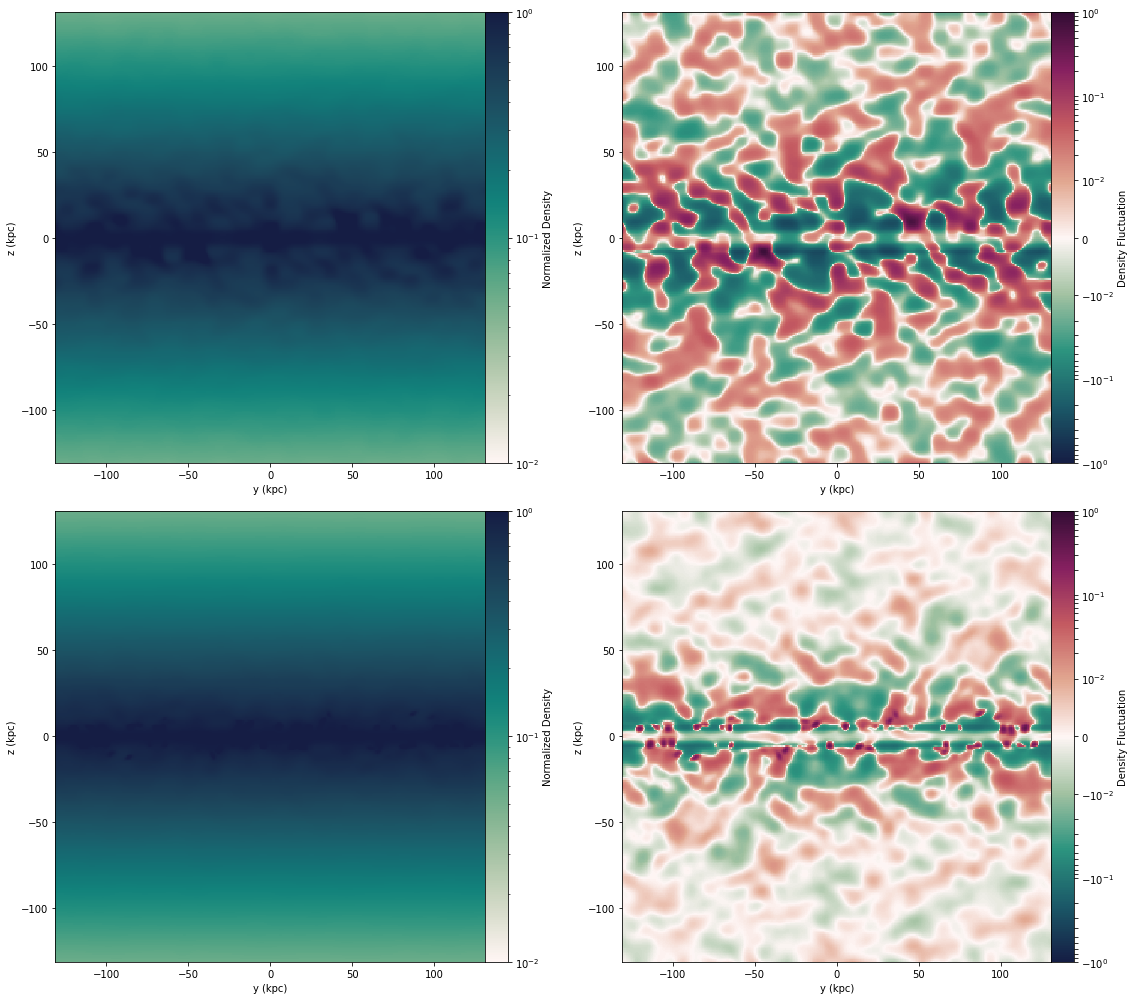


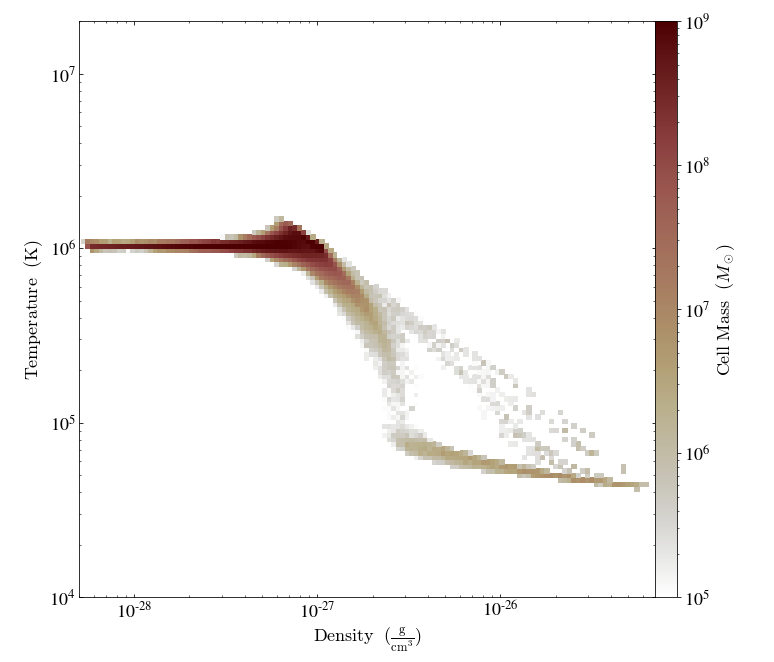


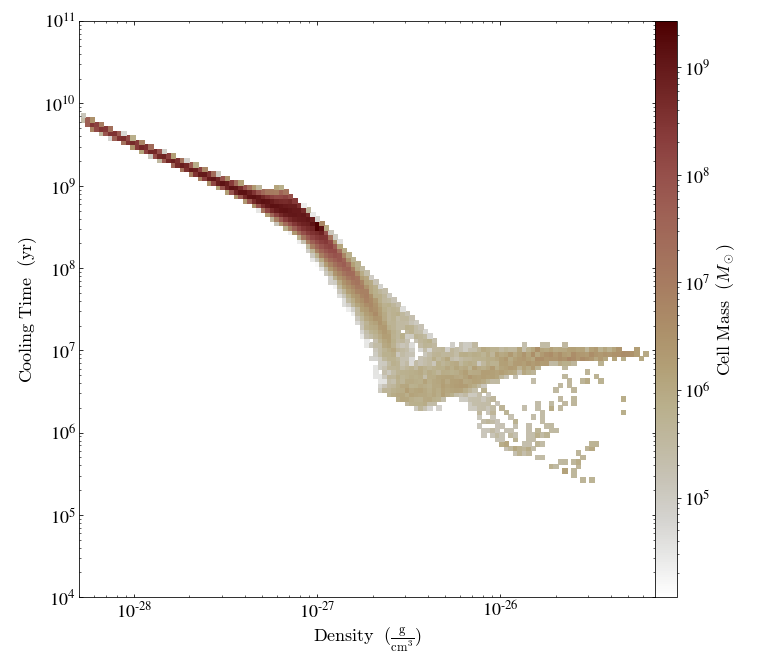


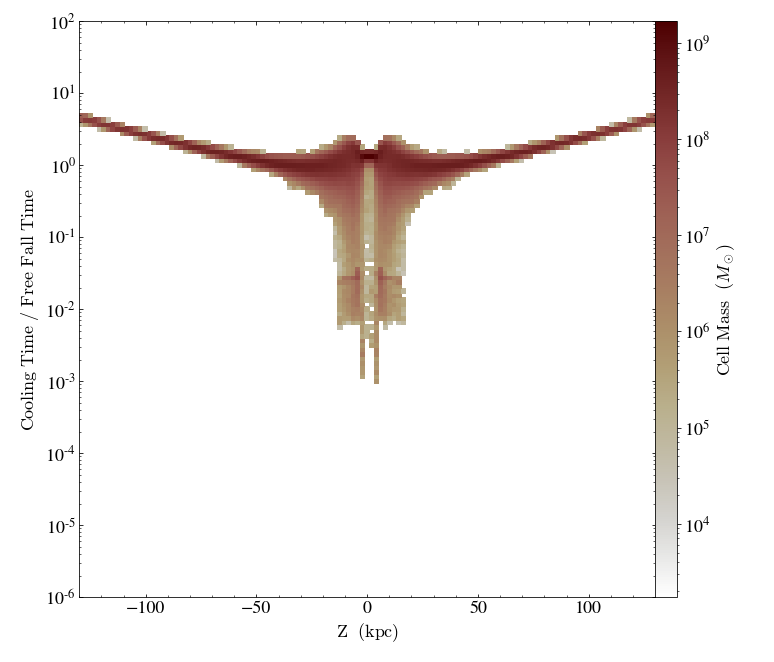

yt : [INFO     ] 2019-10-16 13:06:29,186 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-10-16 13:06:29,187 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-10-16 13:06:29,188 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-10-16 13:06:29,189 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-10-16 13:06:29,190 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800



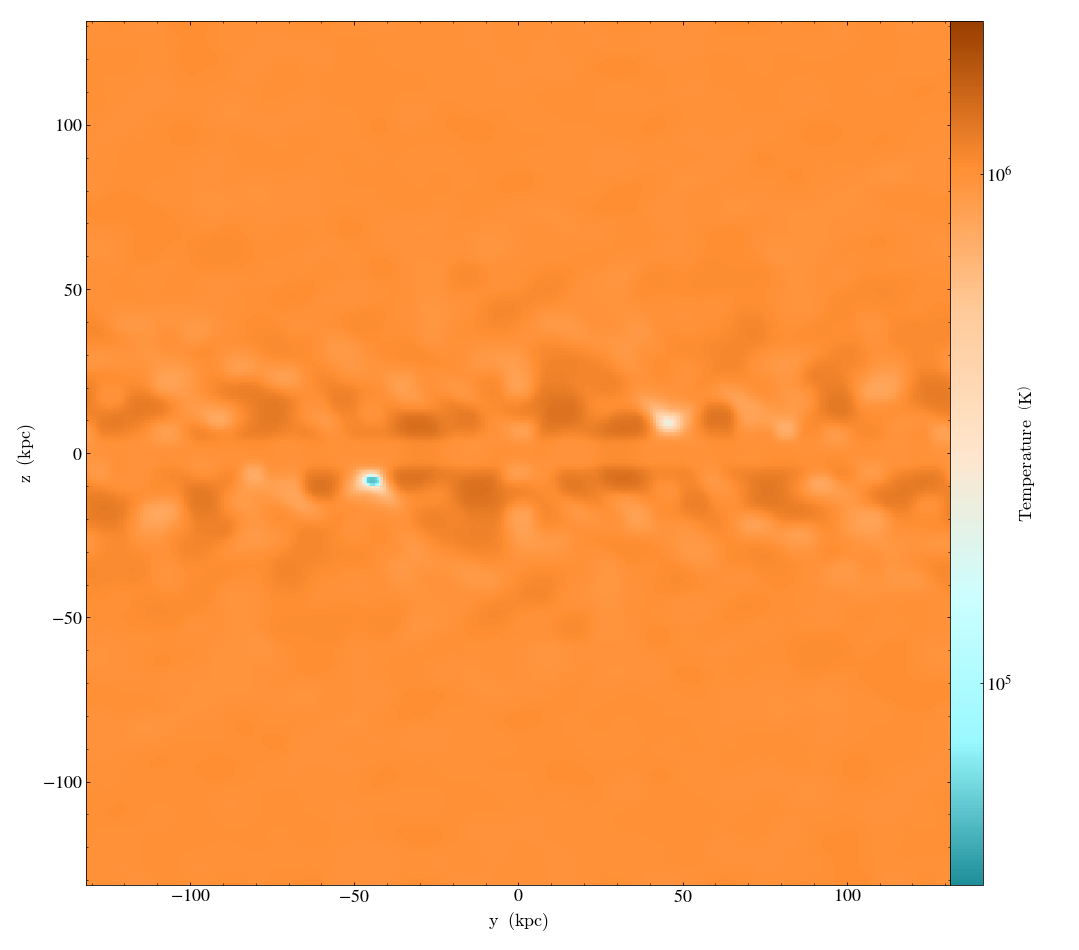

yt : [INFO     ] 2019-10-16 13:06:32,959 Projection completed
yt : [INFO     ] 2019-10-16 13:06:32,962 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-10-16 13:06:32,963 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-10-16 13:06:32,964 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-10-16 13:06:32,965 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-10-16 13:06:32,967 Making a fixed resolution buffer of (('gas', 'velocity_z')) 800 by 800
yt : [WARNING  ] 2019-10-16 13:06:33,004 Plot image for field ('gas', 'velocity_z') has both positive and negative values. Min = -1375059.238692, Max = 1477790.594984.
yt : [WARNING  ] 2019-10-16 13:06:33,006 Switching to symlog colorbar scaling unless linear scaling is specified later



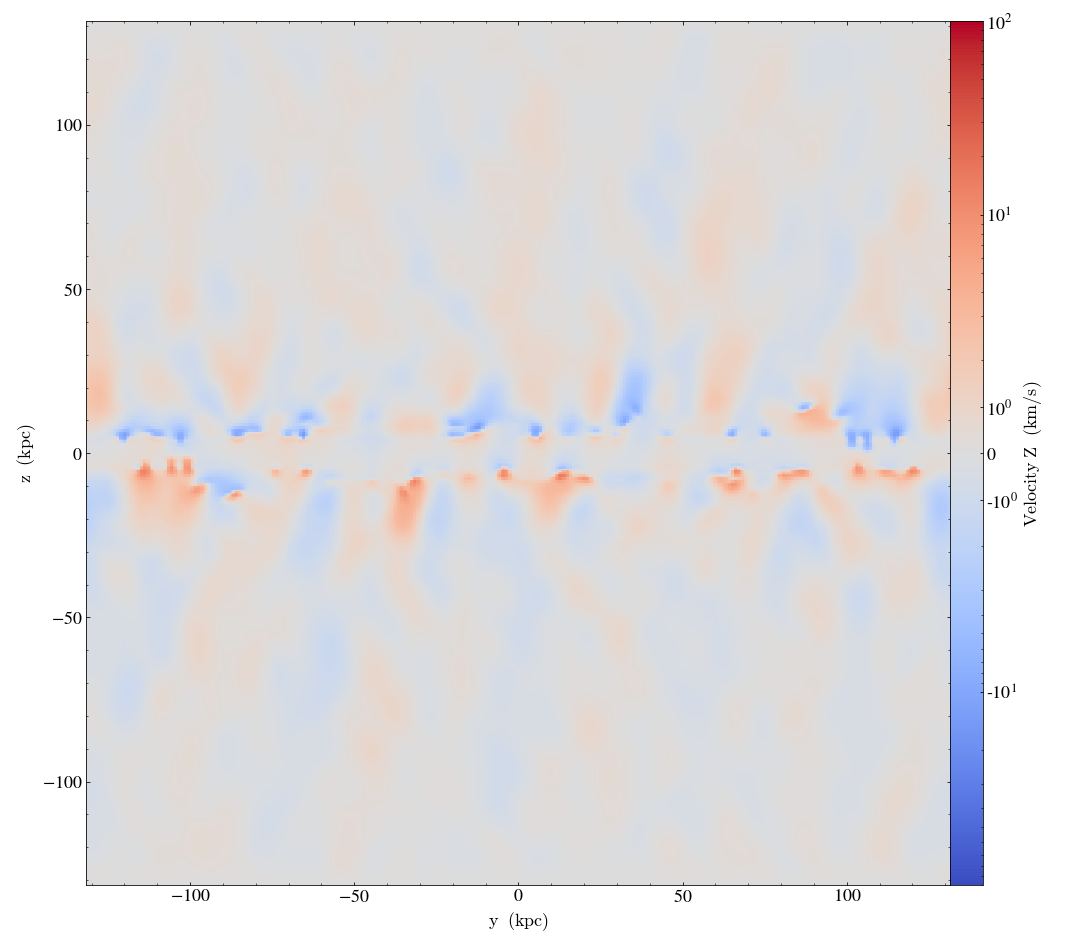

yt : [INFO     ] 2019-10-16 13:06:33,701 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-10-16 13:06:33,702 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-10-16 13:06:33,704 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-10-16 13:06:33,705 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-10-16 13:06:33,707 Making a fixed resolution buffer of (('gas', 'cooling_time')) 800 by 800



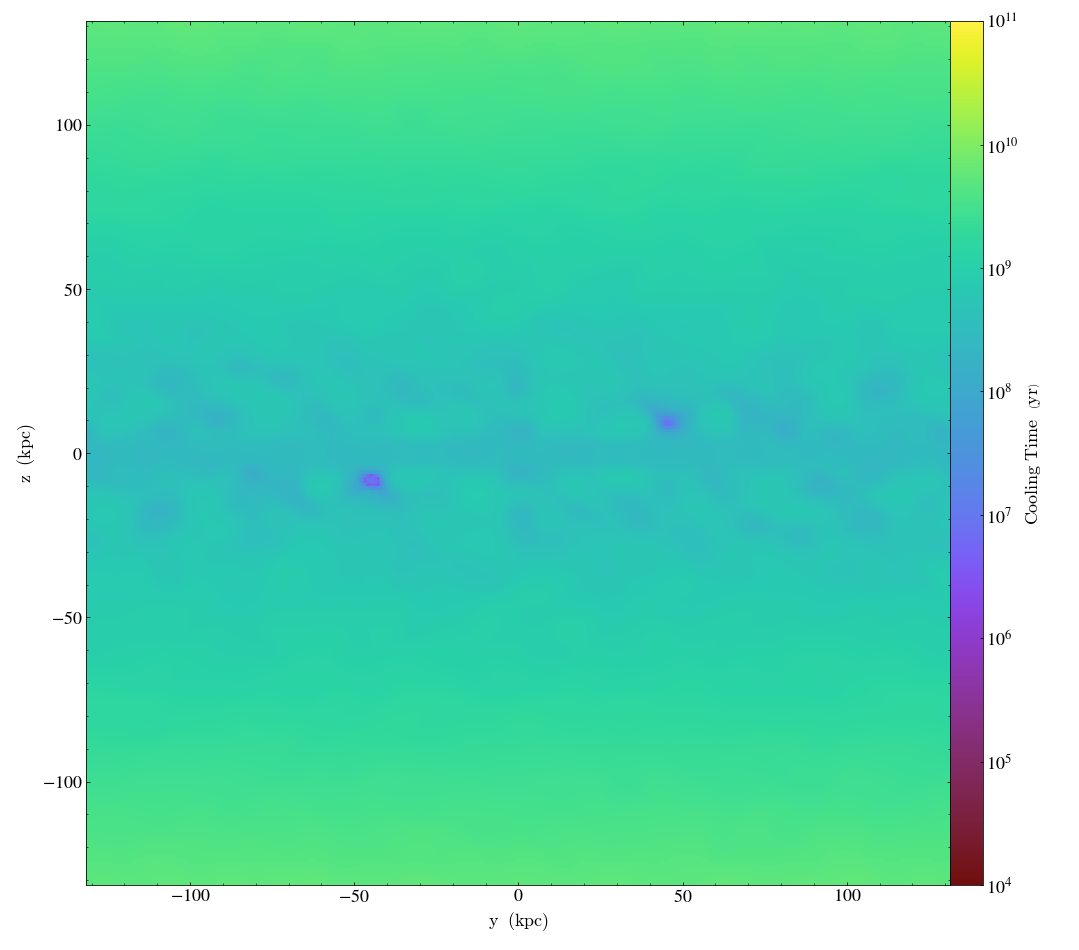

yt : [INFO     ] 2019-10-16 13:06:37,394 Projection completed
yt : [INFO     ] 2019-10-16 13:06:37,395 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-10-16 13:06:37,396 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-10-16 13:06:37,398 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-10-16 13:06:37,399 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-10-16 13:06:37,401 Making a fixed resolution buffer of (('gas', 'pressure')) 800 by 800



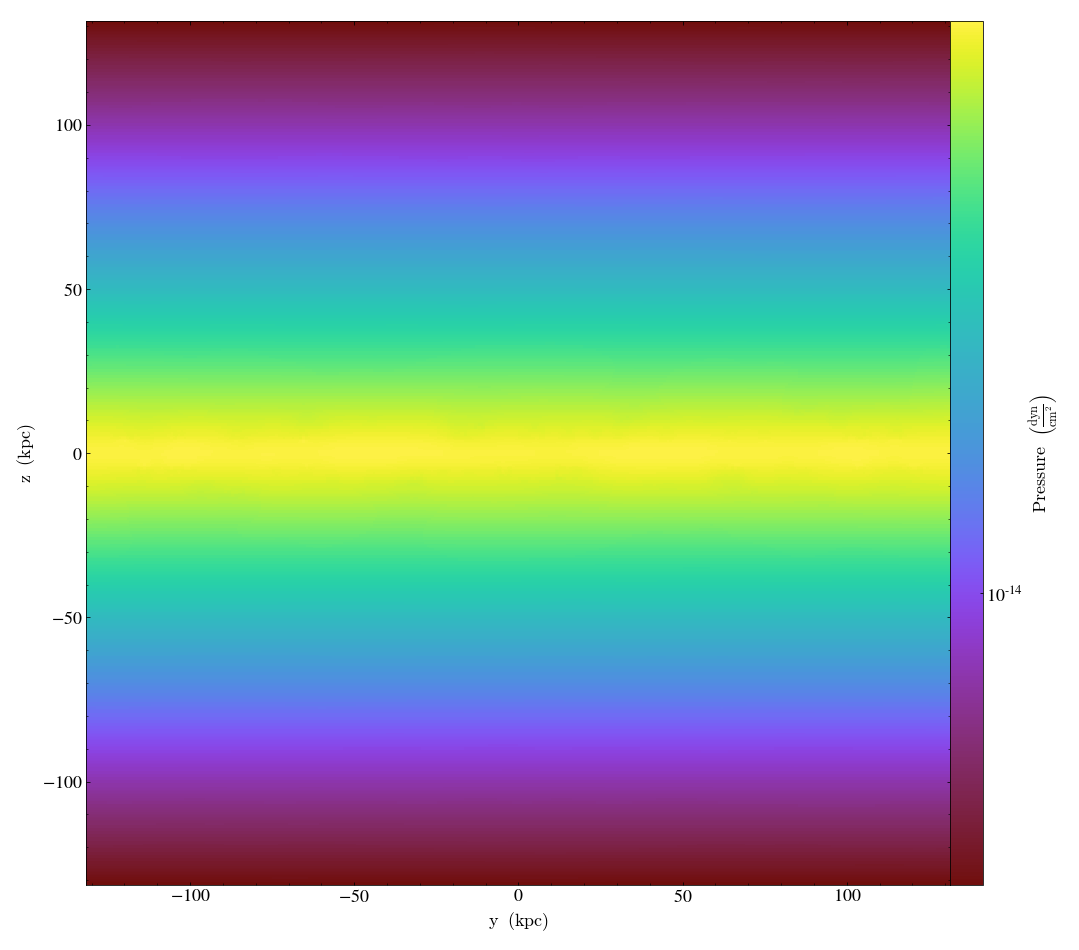

In [23]:
folder = 'isentropic_sf0.01'
#folder = 'isothermal_sf0.01'
folder = 'isothermal'
#folder = 'kmin_4_kmax_32_alpha_0/tcool_tff_1.0'
#folder = 'lowres_cluster'
#folder = 'lowres_isothermal'
#folder = 'lowres_isentropic'
#folder = 'isentropic'
#folder = 'lowres_cluster'
folder = 'isothermal_Tmin1e5'
folder = 'isentropic_Tmin1e5'

#folder = 'cooling_test'
#folder = 'cooling_heating_test'
#folder = 'cluster'
folder = 'isothermal_tctf_1.0'
folder = 'isentropic_tctf_10.0'
#folder = 'isothermal_64'
folder = 'isothermal_256'

half_range = 1
rho0 = 1e-27
view = 'x'
for i in [13]:
    ds = load(i, folder = folder)
    ad = ds.all_data()
    rho = ad[('gas', 'density')]
    high_rho = rho[rho > 1e-26]
    print(len(high_rho) / len(rho))

    plot_density_slices(ds, half_range = half_range, rho0 = rho0)
    
    p = yt.PhasePlot(ad, ('gas', 'density'), ('gas', 'temperature'), \
                         ('gas', 'cell_mass'), weight_field = None)
    p.set_xlim(5e-29, 7e-26)
    p.set_ylim(1e4, 2e7)
    p.set_unit(('gas', 'cell_mass'), 'Msun')
    p.set_zlim(('gas', 'cell_mass'), 1e5, 1e9)
    p.set_cmap(('gas', 'cell_mass'), palettable.scientific.sequential.Bilbao_16.mpl_colormap)
    p.show()
    
    
    p = yt.PhasePlot(ad, ('gas', 'density'), ('gas', 'cooling_time'), \
                         ('gas', 'cell_mass'), weight_field = None)
    p.set_xlim(5e-29, 7e-26)
  #  p.set_ylim(1e4, 1e11)
    p.set_unit(('gas', 'cooling_time'), 'yr')
    p.set_ylim(1e4, 1e11)
    p.set_unit(('gas', 'cell_mass'), 'Msun')
   # p.set_zlim(('gas', 'cell_mass'), 1e5, 1e9)
    p.set_cmap(('gas', 'cell_mass'), palettable.scientific.sequential.Bilbao_16.mpl_colormap)   
    p.show()
    
    xfield = ('gas', 'z')
    yfield = ('gas', 'tcool_tff_ratio')
    zfield = ('gas', 'cell_mass')
   # zfield = ('gas', 'courant_time_step')
    p = yt.PhasePlot(ad, xfield, yfield, zfield, weight_field = None)
    p.set_unit(xfield, 'kpc')
    p.set_unit(zfield, 'Msun')
    p.set_log(xfield, False)
  #  p.set_xlim(0, ds.domain_right_edge[2].in_units('kpc'))
    p.set_ylim(1e-6, 100)
    p.set_cmap(('gas', 'cell_mass'), palettable.scientific.sequential.Bilbao_16.mpl_colormap)
    p.show()
        
        

    field = ('gas', 'temperature')
    s = yt.SlicePlot(ds, view, field, window_size = 12)
    s.set_cmap(field, 'coolwarm')
    s.set_zlim(field, 4e4, 2e6)
#    s.set_log(field, False)
    s.set_cmap(field, palettable.lightbartlein.diverging.BlueDarkOrange12_7.mpl_colormap)
    s.show()
    
    
    field = ('gas', 'velocity_z')
    s = yt.ProjectionPlot(ds, view, field, window_size = 12, weight_field = 'Density')
    s.set_cmap(field, 'coolwarm')
    s.set_unit(field, 'km/s')
    s.set_zlim(field, -100, 100)
    #s.set_zlim(field, -1e7, 1e7)
    #s.set_log(field, False)
    s.show()
    
    field = ('gas', 'cooling_time')
    s = yt.SlicePlot(ds, view, field, window_size = 12)
    s.set_unit(field, 'yr')
    s.set_zlim(field, 1e4, 1e11)
    s.show()
    
    field = ('gas', 'pressure')
    s = yt.ProjectionPlot(ds, view, field, window_size = 12, weight_field = 'ones')
 #   s.set_unit(field, 'Gyr')
    s.show()


In [420]:
ad = ds.all_data()
ct = ad[('gas', 'cooling_time')].in_units('yr')

#print(min(ct))

In [421]:
region =ds.r[:, :, -3.0]
z = region[('gas', 'z')].in_units('kpc')
print(z)

region[('gas', 'cooling_time')]

[-130.53291337 -130.53291337 -130.53291337 ... -130.53291337 -130.53291337
 -130.53291337] kpc


YTArray([0., 0., 0., ..., 0., 0., 0.]) s

[-129.51312499 -127.47354822 -125.43397145 -123.39439467 -121.3548179
 -119.31524113 -117.27566436 -115.23608759 -113.19651082 -111.15693404
 -109.11735727 -107.0777805  -105.03820373 -102.99862696 -100.95905019
  -98.91947342  -96.87989664  -94.84031987  -92.8007431   -90.76116633
  -88.72158956  -86.68201279  -84.64243602  -82.60285924  -80.56328247
  -78.5237057   -76.48412893  -74.44455216  -72.40497539  -70.36539862
  -68.32582184  -66.28624507  -64.2466683   -62.20709153  -60.16751476
  -58.12793799  -56.08836122  -54.04878444  -52.00920767  -49.9696309
  -47.93005413  -45.89047736  -43.85090059  -41.81132382  -39.77174704
  -37.73217027  -35.6925935   -33.65301673  -31.61343996  -29.57386319
  -27.53428641  -25.49470964  -23.45513287  -21.4155561   -19.37597933
  -17.33640256  -15.29682579  -13.25724901  -11.21767224   -9.17809547
   -7.1385187    -5.09894193   -3.05936516   -1.01978839]


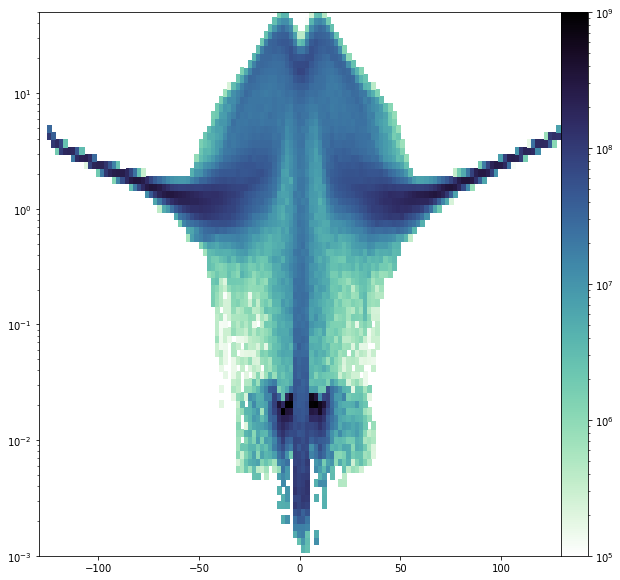

In [395]:
prof = p.profile
xbins = prof.x.d
#xbins[xbins < 0] *= -1
print(xbins[xbins<0])
ybins = prof.y.d
zbins = prof[('gas', 'cell_mass')].d.T

cmap = palettable.cubehelix.jim_special_16_r.mpl_colormap

fig, ax = plt.subplots(figsize = (11,10))
ax.set_yscale('log')
ax.set_ylim(1e-3, 50)
pm = ax.pcolormesh(xbins, ybins, zbins, norm = LogNorm(), cmap =  cmap, vmin = 1e5, vmax = 1e9)
cbar = fig.colorbar(pm, ax = ax, pad = 0)

In [181]:
pal = palettable.scientific.sequential.Tokyo_3_r


AttributeError: 'ScientificMap' object has no attribute 'sequential'


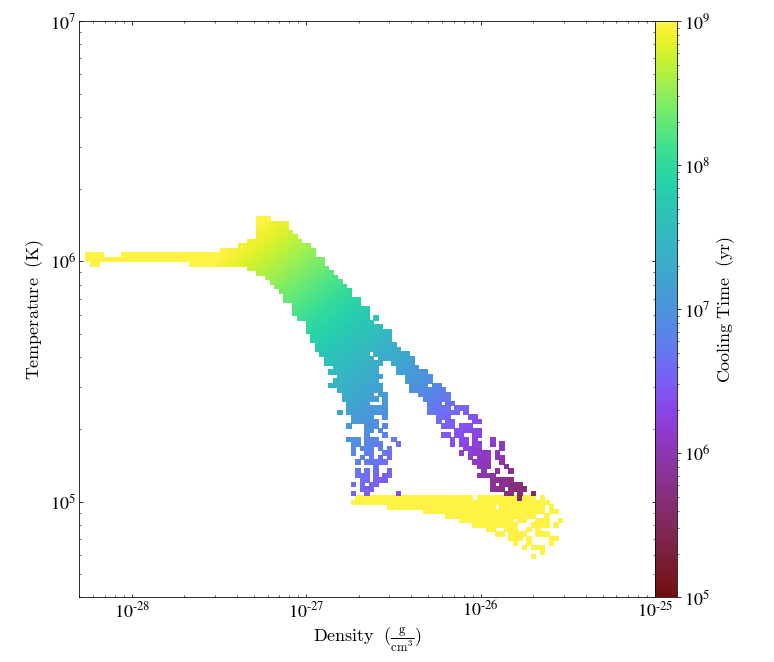

In [100]:
folder = 'isothermal'
#ds = load(31, folder = folder)
zfield = ('gas', 'courant_time_step')
zfield = ('gas', 'cooling_time')

xfield = ('gas', 'density')
yfield = ('gas', 'temperature')
p = yt.PhasePlot(ad, xfield, yfield, zfield, weight_field = 'ones')
p.set_unit(zfield, 'yr')
p.set_zlim(zfield, 1e5, 1e9)
p.set_xlim(5e-29, 1e-25)
p.set_ylim(4e4, 1e7)
p.show()

In [9]:
folder = 'test'
for output in [0, 100]:
    ds = load(output, folder = folder)
    ad = ds.all_data()
    eth = ad[('enzo', 'GasEnergy')]
    etot = ad[('enzo', 'TotalEnergy')]
    rho = ad[('enzo', 'Density')]
    print("%e %e "%(np.sum(rho*eth), np.sum(rho*etot)))

yt : [INFO     ] 2019-10-15 08:22:08,367 Parameters: current_time              = 0
yt : [INFO     ] 2019-10-15 08:22:08,368 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-10-15 08:22:08,369 Parameters: domain_left_edge          = [-3. -3. -3.]
yt : [INFO     ] 2019-10-15 08:22:08,370 Parameters: domain_right_edge         = [3. 3. 3.]
yt : [INFO     ] 2019-10-15 08:22:08,370 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-10-15 08:22:08,375 Gathering a field list (this may take a moment.)
/home/ibutsky/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
/home/ibutsky/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
/home/ibutsky/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Because 'sampling_type' not sp

2.168612e+07 2.168612e+07 
2.384205e+07 2.542671e+07 


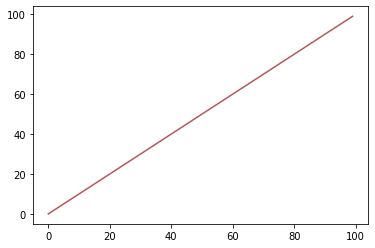

In [22]:
cmap = palettable.wesanderson.Darjeeling4_5.mpl_colors
#cmap[0]
cmap[1]
a = np.arange(0, 100, 1)

plt.plot(a, a, color = cmap[4])


yt : [INFO     ] 2019-10-15 08:28:29,700 Parameters: current_time              = 1.0999990001015
yt : [INFO     ] 2019-10-15 08:28:29,701 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-10-15 08:28:29,702 Parameters: domain_left_edge          = [-3. -3. -3.]
yt : [INFO     ] 2019-10-15 08:28:29,703 Parameters: domain_right_edge         = [3. 3. 3.]
yt : [INFO     ] 2019-10-15 08:28:29,704 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-10-15 08:28:29,710 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2019-10-15 08:28:30,447 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-10-15 08:28:30,448 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-10-15 08:28:30,449 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-10-15 08:28:30,450 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-10-15 08:28:30,451 Making a fixed resolution buffer of (('gas', 'density')) 800 by 800



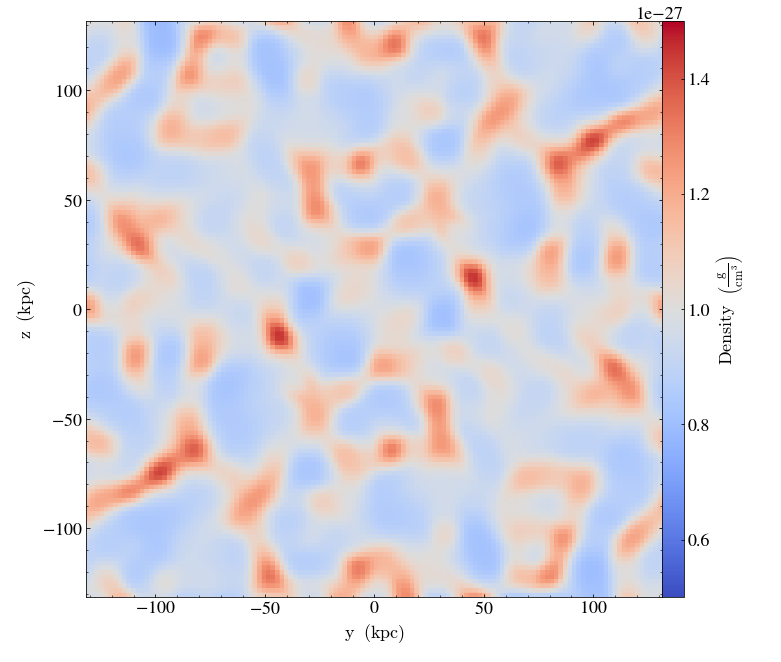

yt : [INFO     ] 2019-10-15 08:28:30,865 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-10-15 08:28:30,866 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-10-15 08:28:30,867 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-10-15 08:28:30,867 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-10-15 08:28:30,868 Making a fixed resolution buffer of (('gas', 'temperature')) 800 by 800



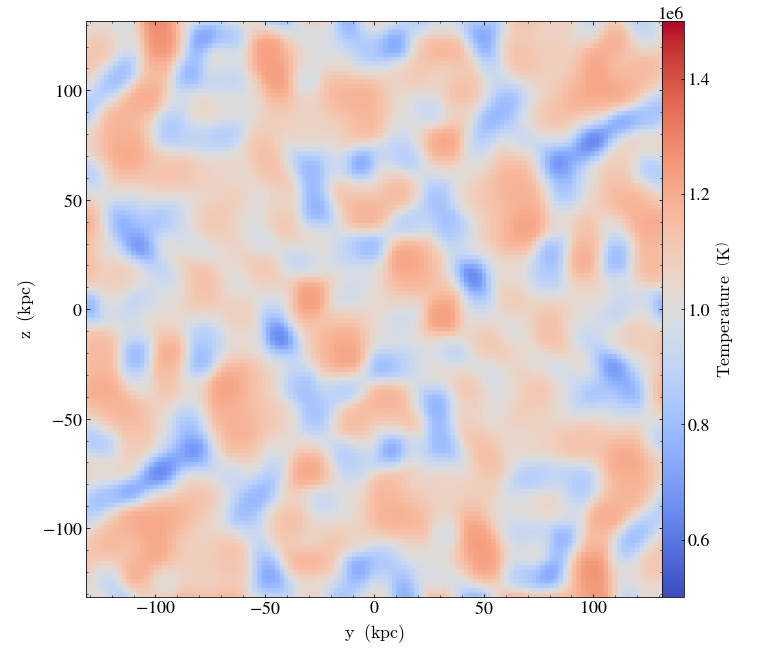

yt : [INFO     ] 2019-10-15 08:28:31,245 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-10-15 08:28:31,245 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-10-15 08:28:31,246 xlim = -3.000000 3.000000
yt : [INFO     ] 2019-10-15 08:28:31,247 ylim = -3.000000 3.000000
yt : [INFO     ] 2019-10-15 08:28:31,248 Making a fixed resolution buffer of (('gas', 'velocity_z')) 800 by 800
yt : [WARNING  ] 2019-10-15 08:28:31,272 Plot image for field ('gas', 'velocity_z') has both positive and negative values. Min = -705725.590538, Max = 706161.420061.
yt : [WARNING  ] 2019-10-15 08:28:31,273 Switching to symlog colorbar scaling unless linear scaling is specified later



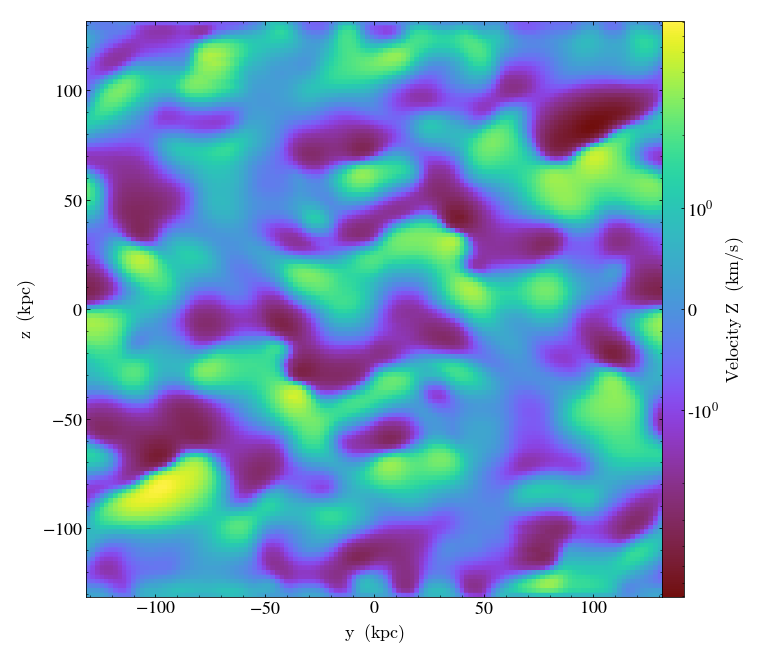

In [16]:
output = 11
ds = yt.load('../../simulations/cooling_heating_test/DD%04d/DD%04d'%(output, output))

field_list = [('gas', 'density'), ('gas', 'temperature')]
zlim_list = [(0.5e-27, 1.5e-27), (0.5e6, 1.5e6)]
for field, zlim in zip(field_list, zlim_list):   
    s = yt.SlicePlot(ds, 'x', field)
    s.set_log(field, False)
    s.set_zlim(field, zlim[0], zlim[1])
    s.set_cmap(field, 'coolwarm')
    s.show()

field = ('gas', 'velocity_z')
s = yt.SlicePlot(ds, 'x', field)
s.set_unit(field, 'km/s')
s.show()

In [21]:
Lambda0 = 4.490093e-19
mu = 1.22
mh = 1.67e-24
kb = 1.38e-16

output = 0
ct = 2.98e8
ds = yt.load('../../simulations/cooling_test/DD%04d/DD%04d'%(output, output))
ad = ds.all_data()
rho = ad[('gas', 'density')]
e = ad[('gas', 'thermal_energy')]
E = rho*e
T = ad[('gas', 'temperature')]
n = rho / (mu * mh)

cool_rate = n*n * Lambda0 * T**(-2./3.)
print(cool_rate)
print(eth)
print("%e"%ds.current_time.in_units('yr'))
print(E.in_units('erg/cm**3'))
print(ad[('gas', 'temperature')])
print(ad[('gas', 'density')])
print(ad[('gas', 'cooling_time')].in_units('yr'))

output = 1
ct = 2.98e8
ds = yt.load('../../simulations/cooling_test/DD%04d/DD%04d'%(output, output))
ad = ds.all_data()
rho = ad[('gas', 'density')]
e = ad[('gas', 'thermal_energy')]
E = rho*e
T = ad[('gas', 'temperature')]
n = rho / (mu * mh)

eth = 3 * n * kb * T / 2.0 
print("%e"%ds.current_time.in_units('s'))
print(E.in_units('erg/cm**3'))
print(ad[('gas', 'temperature')])
print(ad[('gas', 'density')])
print(ad[('gas', 'cooling_time')].in_units('yr'))

yt : [INFO     ] 2019-10-14 14:24:35,435 Parameters: current_time              = 0
yt : [INFO     ] 2019-10-14 14:24:35,436 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-10-14 14:24:35,438 Parameters: domain_left_edge          = [-3. -3. -3.]
yt : [INFO     ] 2019-10-14 14:24:35,439 Parameters: domain_right_edge         = [3. 3. 3.]
yt : [INFO     ] 2019-10-14 14:24:35,441 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-10-14 14:24:35,449 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2019-10-14 14:24:36,354 Parameters: current_time              = 0.010269792348777
yt : [INFO     ] 2019-10-14 14:24:36,355 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-10-14 14:24:36,355 Parameters: domain_left_edge          = [-3. -3. -3.]
yt : [INFO     ] 2019-10-14 14:24:36,356 Parameters: domain_right_edge         = [3. 3. 3.]
yt : [INFO     ] 2019-10-14 14:24:36,357 Parameters: cosmological_simulation   

[1.0816898e-29 1.0816898e-29 1.0816898e-29 ... 1.0816898e-29 1.0816898e-29
 1.0816898e-29] g**2/(K**(2/3)*cm**6)
[9.90208715e-14 9.90208715e-14 9.90208715e-14 ... 9.90208715e-14
 9.90208715e-14 9.90208715e-14] K*g/cm**3
0.000000e+00
[1.01488637e-13 1.01488637e-13 1.01488637e-13 ... 1.01488637e-13
 1.01488637e-13 1.01488637e-13] erg/cm**3
[1000000. 1000000. 1000000. ... 1000000. 1000000. 1000000.] K
[1.e-27 1.e-27 1.e-27 ... 1.e-27 1.e-27 1.e-27] g/cm**3
[2.9824506e+08 2.9824506e+08 2.9824506e+08 ... 2.9824506e+08 2.9824506e+08
 2.9824506e+08] yr
2.389293e+14
[9.89122595e-14 9.89122595e-14 9.89122595e-14 ... 9.89122595e-14
 9.89122595e-14 9.89122595e-14] erg/cm**3
[974614.12366163 974614.12366163 974614.12366163 ... 974614.12366163
 974614.12366163 974614.12366163] K
[1.e-27 1.e-27 1.e-27 ... 1.e-27 1.e-27 1.e-27] g/cm**3
[2.85733455e+08 2.85733455e+08 2.85733455e+08 ... 2.85733455e+08
 2.85733455e+08 2.85733455e+08] yr


In [22]:
E0 = 1.01488637e-13
dt = 2.389293e+14

cool_rate = 1.0816898e-29

E0 - cool_rate * dt 



9.89041631326886e-14

In [46]:
ds.derived_field_list

[('enzo', 'Bx'),
 ('enzo', 'By'),
 ('enzo', 'Bz'),
 ('enzo', 'Cooling_Time'),
 ('enzo', 'Density'),
 ('enzo', 'External_Acceleration_x'),
 ('enzo', 'External_Acceleration_y'),
 ('enzo', 'External_Acceleration_z'),
 ('enzo', 'GasEnergy'),
 ('enzo', 'Phi'),
 ('enzo', 'Temperature'),
 ('enzo', 'TotalEnergy'),
 ('enzo', 'cell_volume'),
 ('enzo', 'dx'),
 ('enzo', 'dy'),
 ('enzo', 'dz'),
 ('enzo', 'path_element_x'),
 ('enzo', 'path_element_y'),
 ('enzo', 'path_element_z'),
 ('enzo', 'vertex_x'),
 ('enzo', 'vertex_y'),
 ('enzo', 'vertex_z'),
 ('enzo', 'x'),
 ('enzo', 'x-velocity'),
 ('enzo', 'y'),
 ('enzo', 'y-velocity'),
 ('enzo', 'z'),
 ('enzo', 'z-velocity'),
 ('gas', 'H_nuclei_density'),
 ('gas', 'He_nuclei_density'),
 ('gas', 'alfven_speed'),
 ('gas', 'angular_momentum_magnitude'),
 ('gas', 'angular_momentum_x'),
 ('gas', 'angular_momentum_y'),
 ('gas', 'angular_momentum_z'),
 ('gas', 'averaged_density'),
 ('gas', 'baroclinic_vorticity_magnitude'),
 ('gas', 'baroclinic_vorticity_x'),
 ('

In [31]:
# calculate cold fraction by mass
T0 = 1e6

ds = yt.load('../../simulations/isothermal_Tmin1e5/DD0100/DD0100')
ad = ds.all_data()
cold = ad[('gas', 'temperature')] <= T0/3.
hot = ad[('gas', 'temperature')] > T0/3.

total_mass = np.sum(ad[('gas', 'cell_mass')].in_units('Msun'))

cold_mass = np.sum(ad[('gas', 'cell_mass')][cold].in_units('Msun'))
hot_mass = np.sum(ad[('gas', 'cell_mass')][hot].in_units('Msun'))

print("test: %e"%ad.quantities.total_quantity(('gas', 'cell_mass')).in_units('Msun'))
print("cold: %e, hot = %e, total = %e"%(cold_mass, hot_mass, cold_mass + hot_mass))
print(cold_mass / total_mass)

yt : [INFO     ] 2019-10-15 09:18:08,365 Parameters: current_time              = 9.9999990135785
yt : [INFO     ] 2019-10-15 09:18:08,366 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-10-15 09:18:08,367 Parameters: domain_left_edge          = [-3. -3. -3.]
yt : [INFO     ] 2019-10-15 09:18:08,368 Parameters: domain_right_edge         = [3. 3. 3.]
yt : [INFO     ] 2019-10-15 09:18:08,370 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-10-15 09:18:08,377 Gathering a field list (this may take a moment.)


test: 9.274499e+10
cold: 4.599638e+10, hot = 4.674861e+10, total = 9.274499e+10
0.4959446439937183 dimensionless


yt : [INFO     ] 2019-10-15 09:59:05,059 Parameters: current_time              = 0
yt : [INFO     ] 2019-10-15 09:59:05,060 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-10-15 09:59:05,061 Parameters: domain_left_edge          = [-3. -3. -3.]
yt : [INFO     ] 2019-10-15 09:59:05,062 Parameters: domain_right_edge         = [3. 3. 3.]
yt : [INFO     ] 2019-10-15 09:59:05,063 Parameters: cosmological_simulation   = 0.0
yt : [INFO     ] 2019-10-15 09:59:05,070 Gathering a field list (this may take a moment.)
yt : [INFO     ] 2019-10-15 09:59:05,925 Parameters: current_time              = 1.0999993174584
yt : [INFO     ] 2019-10-15 09:59:05,927 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2019-10-15 09:59:05,928 Parameters: domain_left_edge          = [-3. -3. -3.]
yt : [INFO     ] 2019-10-15 09:59:05,929 Parameters: domain_right_edge         = [3. 3. 3.]
yt : [INFO     ] 2019-10-15 09:59:05,930 Parameters: cosmological_simulation   = 

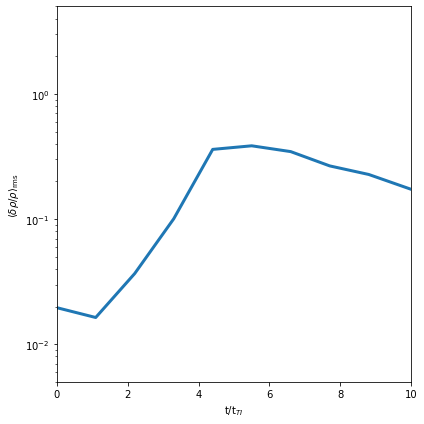

In [104]:
# calculating <drho / rho>
# code units = scale height units
def calculate_drho_rms(output):
    ds = yt.load('../../simulations/isothermal_Tmin1e5/DD%04d/DD%04d'%(output, output))

    region1 = ds.r[0, 0, 0.9:1.1]
    region2 = ds.r[0, 0, -1.1:-0.9]
    zlist = np.append(region1[('gas', 'z')].in_units('kpc'), region2[('gas', 'z')].in_units('kpc'))

    drho = np.array([])
    for z in zlist:
        zslice = ds.r[:, :, YTQuantity(z, 'kpc')]
        rho = zslice[('gas', 'density')]
        rho_ave = np.mean(rho)
        drho = np.append(drho, (rho - rho_ave) / rho_ave)

    drho_rms = np.sqrt(np.mean(drho**2))
    return ds.current_time, drho_rms

fig, ax = plt.subplots(figsize = (6, 6))
ax.set_yscale('log')
ax.set_ylim(5e-3, 5)
ax.set_xlim(0, 10)
time_list = []
drho_rms_list = []
for output in np.linspace(0, 100, 10):
    time, drho_rms = calculate_drho_rms(output)
    time_list.append(time)
    drho_rms_list.append(drho_rms)

ax.plot(time_list, drho_rms_list, linewidth = 3)
    
ax.set_xlabel('t/t$_{TI}$')
ax.set_ylabel('$ \\langle \\delta \\rho / \\rho\\rangle_{\\mathrm{rms}}$ ')
fig.tight_layout()
    


In [6]:
ad = ds.all_data()

In [76]:
T = np.logspace(np.log10(1e4), 7, 1000)

(1e-25, 1e-21)

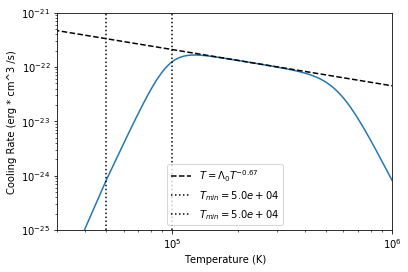

In [402]:
T = np.logspace(np.log10(1e4), 9, 1000)
def cooling_rate(T, Tmin = 5e4, Tmax = 1e6, power_law_index = -2./3.):
    factor = 0.02
    logT = np.log10(T)
    logT_min = np.log10(Tmin)
    logT_max = np.log10(Tmax)
    
    Tminscale = (logT - logT_min)/(factor * logT_min) 
    Tmaxscale = -(logT - logT_max) / (factor * logT_max)
    
    L0 =  4.49009e-19
    cooling_rate =  L0 * np.power(T, power_law_index)
    cooling_rate[T < Tmin] = L0 * np.power(Tmin, power_law_index)
    cooling_rate[T > Tmax] = L0 * np.power(Tmax, power_law_index)
    
    ymin = 1e-10
    smooth_min = (np.tanh(Tminscale - 2.0) + 1.0) / 2. #* (1.0 - ymin) / 2 + ymin
    smooth_max = (np.tanh(Tmaxscale - 2.0) + 1.0) /2. #* (1.0 - ymin) / 2 + ymin)
    return cooling_rate * smooth_min * smooth_max 

Tmin = 5e4
L0 =  4.49009e-19

power_law_index = -2/3
#power_law_index = 1
cool1 = cooling_rate(T, Tmin = Tmin, power_law_index = power_law_index)
plt.loglog(T, cool1)
plt.loglog(T, L0*T**(power_law_index), color = 'black', linestyle = 'dashed', \
           label = '$ T = \Lambda_0 T^{%0.2f}$'%(power_law_index))
plt.axvline(Tmin, color = 'black', linestyle = 'dotted', label = '$T_{min} = %.1e$'%(Tmin))
plt.axvline(1e5, color = 'black', linestyle = 'dotted', label = '$T_{min} = %.1e$'%(Tmin))

plt.xlabel('Temperature (K)')
plt.ylabel('Cooling Rate (erg * cm^3 /s)')
plt.legend()
plt.xlim(3e4, 1e6)
plt.ylim(1e-25, 1e-21)


4.698970004336019


array([0.01000034, 0.01000081, 0.01000192, 0.01000453, 0.0100107 ,
       0.01002527, 0.01005971, 0.01014108, 0.01033327, 0.01078709,
       0.01185773, 0.01437825, 0.02028296, 0.03395749, 0.0647996 ,
       0.13039839, 0.25403259, 0.44161096, 0.64972449, 0.81374517,
       0.91157716, 0.9605446 , 0.98290857, 0.99269371, 0.99689457,
       0.99868332, 0.99944232, 0.9997639 , 0.99990006, 0.9999577 ,
       0.9999821 , 0.99999242, 0.99999679, 0.99999864, 0.99999943,
       0.99999976, 0.9999999 , 0.99999996, 0.99999998, 0.99999999,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

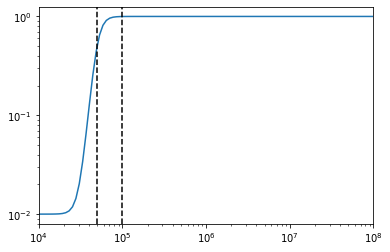

In [352]:
T = np.logspace(4, 8, 100)
logT = np.log10(T)
Tmin = 5e4
logT_min = np.log10(Tmin)

def tanh_smooth(x, xmin, smooth = 0.1):
    xscale = (x - xmin) / xmin / smooth
    ymin = 1e-2
    tanh = (np.tanh(xscale) + 1) * (1.0 - ymin ) / 2.0 + ymin
    return tanh
print(logT_min)
smooth = 0.02
pli = 0
cool = T**(pli)
cool[T < Tmin] = Tmin**(pli)
func = cool * tanh_smooth(logT, logT_min, smooth = smooth)
plt.loglog(T,func)
plt.axvline(5e4, color = 'black', linestyle = 'dashed')
plt.axvline(1e5, color = 'black', linestyle = 'dashed')

plt.xlim(1e4, 1e8)
tanh_smooth(logT, logT_min, smooth = smooth)

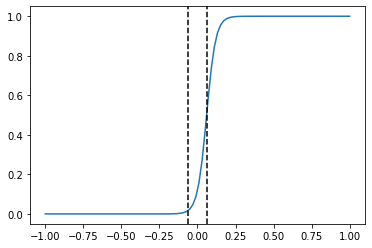

In [349]:
factor = 0.06
x = np.linspace(-1, 1, 100)
plt.plot(x, (np.tanh( x / factor - 1) + 1) / 2.0)
plt.axvline(-factor, color = 'black', linestyle = 'dashed')
plt.axvline(factor, color = 'black', linestyle = 'dashed')

In [350]:
T

array([-16.66666667, -16.32996633, -15.99326599, -15.65656566,
       -15.31986532, -14.98316498, -14.64646465, -14.30976431,
       -13.97306397, -13.63636364, -13.2996633 , -12.96296296,
       -12.62626263, -12.28956229, -11.95286195, -11.61616162,
       -11.27946128, -10.94276094, -10.60606061, -10.26936027,
        -9.93265993,  -9.5959596 ,  -9.25925926,  -8.92255892,
        -8.58585859,  -8.24915825,  -7.91245791,  -7.57575758,
        -7.23905724,  -6.9023569 ,  -6.56565657,  -6.22895623,
        -5.89225589,  -5.55555556,  -5.21885522,  -4.88215488,
        -4.54545455,  -4.20875421,  -3.87205387,  -3.53535354,
        -3.1986532 ,  -2.86195286,  -2.52525253,  -2.18855219,
        -1.85185185,  -1.51515152,  -1.17845118,  -0.84175084,
        -0.50505051,  -0.16835017,   0.16835017,   0.50505051,
         0.84175084,   1.17845118,   1.51515152,   1.85185185,
         2.18855219,   2.52525253,   2.86195286,   3.1986532 ,
         3.53535354,   3.87205387,   4.20875421,   4.54

In [372]:
test = np.nan

In [373]:
test

nan

In [375]:
max(test, 1e-20)

nan

In [382]:
cool = -1e10
tiny = -2e-20
min(cool, tiny)

-10000000000.0

In [381]:
cool < tiny


True